# 🧠 Compact Convolutional Transformer (CCT) for CIFAR-10

## 📝 Project Overview

In this project, I implement and train a **Compact Convolutional Transformer (CCT)** from scratch on the CIFAR-10 dataset, achieving over 91% test accuracy.

CCT is a hybrid architecture that combines **convolutional feature extraction** with **transformer-based sequence modeling**, making it well-suited for smaller datasets and lower input resolutions.

Unlike a standard Vision Transformer, which splits raw images into fixed-size patches, CCT applies a **convolutional tokenizer** to generate the sequence. This improves local feature modeling and reduces data-hungriness, making training from scratch on CIFAR-10 more stable.


In [1]:
# Import libraries for training

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from einops.layers.torch import Rearrange
from einops import rearrange
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import MixUp, CutMix, RandomChoice


## 🧰 Data Preparation

I use the standard CIFAR-10 training and test splits with augmentation and normalization to improve generalization and stabilize optimization.

This step mirrors the ViT setup but is especially useful for CCT, as convolutional tokenization already captures local patterns, so well-chosen augmentations help further enrich the dataset variability.


In [2]:
# Define train/test dataloaders with transforms (augmentation + normalization)

def get_dataloaders(batch_size=128):
    normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std =[0.2470, 0.2435, 0.2616]
    )

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        normalize,
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    full_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    # Took the full size sets
    trainloader = DataLoader(full_train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, prefetch_factor=2)
    testloader = DataLoader(full_test, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    return trainloader, testloader

## 🏗 CCT Architecture Design

The Compact Convolutional Transformer modifies the classic ViT structure in two key ways:

1. **Convolutional Tokenizer**
   Instead of dividing the image into non-overlapping patches, CCT uses a convolutional stem to produce tokens. This improves local inductive biases and makes the model more data-efficient on small images.

2. **Sequence Pooling**
   CCT replaces the class token with a learnable **sequence pooling** operation. This aggregates information from all tokens at the end of the transformer, often improving accuracy and stability for small datasets.

The rest of the architecture is similar to ViT:
- Self-attention layers capture long-range dependencies.
- Feedforward layers refine token representations.
- Transformer blocks stack these components with residual connections.
- A linear head performs classification.

The code below defines the key modules: sequence pooling, attention, feedforward, transformer block, and the main CCT model.


In [3]:

class ConvolutionalTokenizer(nn.Module):
    def __init__(self, in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, depth = 1):
        super().__init__()
        self.layers = nn.ModuleList([])
        for i in range(depth):
            in_ch = in_channels if i == 0 else out_channels * i
            out_ch = out_channels * (i + 1)
            self.layers.append(
                nn.Sequential(
                    nn.Conv2d(in_ch,
                            out_ch,
                            kernel_size,
                            stride,
                            padding),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                    )
            )


    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        return x


In [4]:
class SeqPooling(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.attention_pool = nn.Linear(embed_dim, 1)

    def forward(self, x):
        attn = self.attention_pool(x)          # (B, N, 1)
        attn = torch.softmax(attn, dim=1)      # normalize across tokens
        return torch.sum(attn * x, dim=1)      # (B, D)

In [5]:
class Attention(nn.Module):
    def __init__(self, dim, heads=2, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)
        assert dim == heads * dim_head, "dim must be divisible by num_heads"

        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Sequential(nn.Linear(inner_dim, dim), nn.Dropout(dropout)) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3,dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attend = self.attend(dots)
        out = torch.matmul(attend, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [6]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [7]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
            Attention(dim, heads, dim_head, dropout),
            FeedForward(dim, mlp_dim, dropout)]
            ))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [8]:
class MyCCT(nn.Module):
    def __init__(self, * ,in_channels=3, base_conv_dim=64, emb_dim = 128, heads, dim_head=64, num_classes = 10, depth, mlp_dim,  tokenizer_depth = 2,dropout=0.):
        super().__init__()
        assert emb_dim == heads * dim_head, "dim must be divisible by num_heads"
        self.conv_tokenizer = ConvolutionalTokenizer(in_channels, base_conv_dim , depth=tokenizer_depth)
        self.proj = nn.Linear(base_conv_dim * tokenizer_depth, emb_dim)
        self.transformer = Transformer(emb_dim, depth, heads, dim_head, mlp_dim, dropout)
        self.pool = SeqPooling(emb_dim)
        self.out = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        x = self.conv_tokenizer(x)
        x = self.proj(x)
        x = self.transformer(x)
        x = self.pool(x)
        x = self.out(x)
        return x




In [9]:
trainloader, testloader = get_dataloaders()


100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


## 🧪 MixUp & CutMix Strategy

I enable **MixUp** and **CutMix** to improve generalization and robustness on CIFAR-10.

- **MixUp (alpha = `0.8`)**: linearly blends two images and their labels; targets become **soft labels**
  drawn from a Beta(`0.8`, `0.8`) distribution.
- **CutMix (alpha = `1.0`)**: replaces a random patch in one image with a patch from another image and mixes labels by area ratio.

Both techniques implement **vicinal risk minimization**, which smooths decision boundaries and reduces overfitting—especially helpful for transformers trained from scratch on small images.

Implementation notes:
- I instantiate both transforms here and select which one to apply inside the training loop.
- Since labels become **probability vectors**, my loss function is compatible with soft targets (I use cross-entropy with label smoothing; metrics are computed on hard labels for reporting).
- I later **schedule augmentation off** at `mixup_off_epoch` to let the model “lock in” on natural samples near the end of training.


In [10]:
num_classes = 10
mixup_alpha = 0.8
cutmix_alpha = 1.0

mixup = MixUp(alpha=mixup_alpha, num_classes=num_classes)
cutmix = CutMix(alpha=cutmix_alpha, num_classes=num_classes)

# Randomly choose MixUp or CutMix each batch (like switch_prob = 0.5)
mixupcutmix = RandomChoice([mixup, cutmix])

## ⚙️ Model Hyperparameters & Adaptive Learning Rate

I define the CCT model and training hyperparameters with a focus on stability and data-efficiency:

- **CCT hyperparameters**: `emb_dim`, `heads`, `dim_head`, `depth`, `mlp_dim`, and `tokenizer_depth` control model capacity and
  receptive fields. I keep dimensions moderate to balance accuracy, memory, and convergence on 32×32 inputs.
- **Regularization**: `dropout` and `label_smoothing` (in the loss) mitigate overfitting; weight decay is handled via AdamW.

**Adaptive LR schedule**: I use **Linear Warmup ➜ Cosine Annealing** via `SequentialLR`.
- **Warmup** (`warmup` × steps/epoch): linearly ramps the LR from a small factor up to `lr`, preventing early divergence common in transformers.
- **Cosine decay** (to `eta_min`): smoothly reduces LR for the remainder of training, improving late-stage convergence and final accuracy.
- **AdamW** (with `weight_decay`): decouples L2 regularization from gradient updates for better generalization.

I also set `mixup_off_epoch` so MixUp/CutMix are disabled in later epochs, letting the model fine-tune its decision boundaries on unaugmented samples.


In [14]:

model = MyCCT(emb_dim = 256, heads = 4, dim_head=64, num_classes = 10, depth = 7, mlp_dim = 512,  tokenizer_depth = 2, dropout=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 300
lr = 0.0005
weight_decay = 0.06
eta_min = 1e-6
warmup = 10
mixup_off_epoch = 175

# Loss & optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = criterion.to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1/25, end_factor=1.0, total_iters = warmup * len(trainloader))
cosine_scheduler  = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = (num_epochs - warmup) * len(trainloader), eta_min=eta_min)

scheduler = optim.lr_scheduler.SequentialLR(optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[
        warmup * len(trainloader)
    ])



## 🧮 `batch_accuracy` Function

I define a helper function `batch_accuracy(outputs, targets)` to compute classification accuracy per mini-batch during training and evaluation.

Key details:
- The function supports both **hard labels** (standard integer class indices of shape `(B,)`) and **soft labels** (probability distributions of shape `(B, C)`), which are produced by MixUp and CutMix.
- When soft labels are provided, the predicted class is compared to the **argmax** of the target distribution to determine correctness.
- The function returns both the **number of correct predictions** and the **total number of samples**, making it easy to aggregate accuracy over an epoch.

This design allows the training loop to seamlessly handle both regular and mixed-label batches without extra conditional logic.


In [12]:
def batch_accuracy(outputs, targets):
    """Returns (num_correct, num_samples). Handles soft (B,C) and hard (B,) labels."""
    if targets.ndim == 2:                   # soft labels (MixUp/CutMix)
        probs = torch.softmax(outputs, dim=1)
        # soft 'correctness' per sample in [0,1], sum to get batch-equivalent "correct"
        soft_correct = (probs * targets).sum(dim=1).sum().item()
        return soft_correct, targets.size(0)
    else:                                   # hard labels
        preds = outputs.argmax(dim=1)
        return preds.eq(targets).sum().item(), targets.size(0)

In [15]:
# Training and evaluation loop
# Tracks: training loss, training accuracy, test loss, test accuracy

%%time
train_losses, test_losses, train_accs, test_accs = [], [], [], []

for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)


            # Apply MixUp/CutMix until cutoff epoch
            if epoch < mixup_off_epoch:
                inputs, labels = mixupcutmix(inputs, labels)


            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            scheduler.step()

            # Track training loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            batch_correct, batch_total = batch_accuracy(outputs, labels)
            correct += batch_correct
            total   += batch_total

        train_loss = running_loss / total
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluation
        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()

        test_loss /= total_test
        test_acc = 100. * correct_test / total_test
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch [1/300] Train Loss: 2.2104, Train Acc: 12.65% | Test Loss: 1.9532, Test Acc: 31.20%
Epoch [2/300] Train Loss: 2.1173, Train Acc: 15.33% | Test Loss: 1.7880, Test Acc: 41.45%
Epoch [3/300] Train Loss: 2.0670, Train Acc: 17.05% | Test Loss: 1.7458, Test Acc: 39.57%
Epoch [4/300] Train Loss: 2.0309, Train Acc: 18.29% | Test Loss: 1.5726, Test Acc: 51.54%
Epoch [5/300] Train Loss: 1.9973, Train Acc: 19.44% | Test Loss: 1.5387, Test Acc: 52.83%
Epoch [6/300] Train Loss: 1.9498, Train Acc: 21.23% | Test Loss: 1.5307, Test Acc: 52.14%
Epoch [7/300] Train Loss: 1.9508, Train Acc: 21.19% | Test Loss: 1.3947, Test Acc: 58.73%
Epoch [8/300] Train Loss: 1.9278, Train Acc: 22.05% | Test Loss: 1.4194, Test Acc: 58.77%
Epoch [9/300] Train Loss: 1.9021, Train Acc: 23.18% | Test Loss: 1.4638, Test Acc: 57.96%


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [10/300] Train Loss: 1.9132, Train Acc: 22.70% | Test Loss: 1.4292, Test Acc: 58.22%
Epoch [11/300] Train Loss: 1.8910, Train Acc: 23.58% | Test Loss: 1.4012, Test Acc: 59.76%
Epoch [12/300] Train Loss: 1.8624, Train Acc: 24.72% | Test Loss: 1.3284, Test Acc: 64.84%
Epoch [13/300] Train Loss: 1.8446, Train Acc: 25.40% | Test Loss: 1.2936, Test Acc: 64.83%
Epoch [14/300] Train Loss: 1.8270, Train Acc: 26.17% | Test Loss: 1.3262, Test Acc: 63.54%
Epoch [15/300] Train Loss: 1.8317, Train Acc: 25.94% | Test Loss: 1.2549, Test Acc: 67.77%
Epoch [16/300] Train Loss: 1.8359, Train Acc: 25.77% | Test Loss: 1.3047, Test Acc: 64.23%
Epoch [17/300] Train Loss: 1.8195, Train Acc: 26.42% | Test Loss: 1.2699, Test Acc: 67.66%
Epoch [18/300] Train Loss: 1.8088, Train Acc: 26.91% | Test Loss: 1.2251, Test Acc: 68.65%
Epoch [19/300] Train Loss: 1.7750, Train Acc: 28.31% | Test Loss: 1.2125, Test Acc: 69.33%
Epoch [20/300] Train Loss: 1.7730, Train Acc: 28.41% | Test Loss: 1.2183, Test Acc: 71.60%

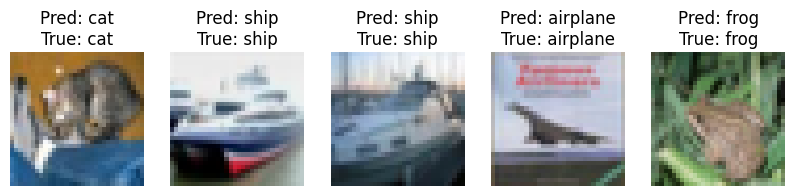

In [16]:
# 🔍 Run inference on a few test images to visualize predictions
import matplotlib.pyplot as plt

classes = trainloader.dataset.classes
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move model to eval mode
model.eval()
images = images.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Show predictions
fig = plt.figure(figsize=(10,4))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    img = images[i].cpu().permute(1, 2, 0)
    img = img * torch.tensor([0.2470, 0.2435, 0.2616]) + torch.tensor([0.4914, 0.4822, 0.4465])  # unnormalize
    ax.imshow(img.clip(0,1))
    ax.set_title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
    ax.axis('off')


In [17]:
# Calculate Model Parameters


total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"~{total_params / 1e6:.2f} million parameters")


Total parameters: 3,795,851
~3.80 million parameters


## 📊 Training Results

After training is complete, I plot the recorded accuracy and loss curves over all epochs.
These plots give insight into training stability, convergence speed, and potential overfitting.
CCT models usually exhibit smoother training curves on small datasets compared to ViTs, thanks to their built-in inductive biases.


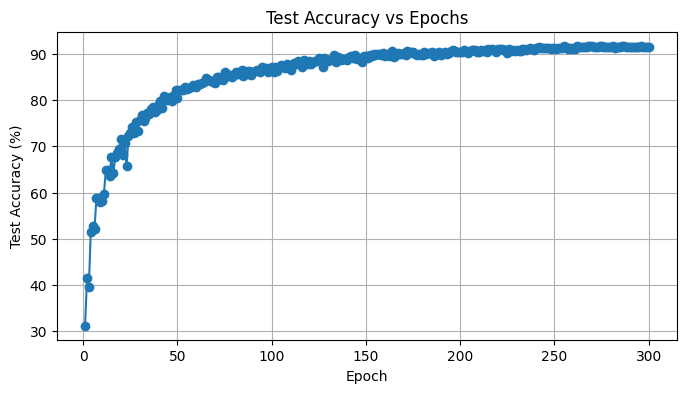

In [18]:
import matplotlib.pyplot as plt
def plot_test_acc():
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_epochs+1), test_accs, marker='o')
    plt.title("Test Accuracy vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True)
    plt.show()
plot_test_acc()

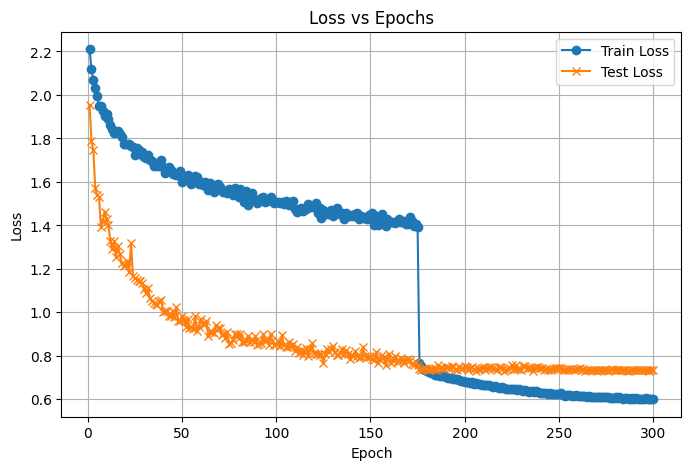

In [19]:
# Plot Train and Test Loss
def plot_train_test_loss():
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss', marker='x')
    plt.title("Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_train_test_loss()

## ✅ Summary & Takeaways

This project demonstrates how I implemented and trained a **Compact Convolutional Transformer (CCT)** from scratch for CIFAR-10 classification.
The model blends convolutional inductive biases with transformer sequence modeling, achieving strong performance on a small dataset without pretraining.

**Key Techniques Used:**
- **Custom CCT architecture** with convolutional tokenizer and sequence pooling
- **Data augmentation** and normalization to improve generalization
- **MixUp and CutMix** with scheduled deactivation to regularize training and smooth decision boundaries
- **Label smoothing** and dropout for additional regularization
- **AdamW optimizer** combined with **Linear Warmup → Cosine Annealing** learning rate scheduling for stable and efficient convergence
- `batch_accuracy` function supporting both hard and soft labels for consistent metric tracking

**Why CCT works well here:**
Compared to a vanilla Vision Transformer, CCT uses a **convolutional tokenizer** instead of patch embeddings, which captures local structures more effectively and improves data efficiency.
Sequence pooling replaces the class token, simplifying the architecture and often stabilizing training on small images.
This design typically converges faster and requires fewer parameters than ViT, making it well-suited for CIFAR-10.

**Results:**
The model trains smoothly with adaptive learning rate scheduling and regularization techniques, achieving over 91% test accuracy.
MixUp and CutMix contribute to better generalization, while turning them off late in training lets the model refine decision boundaries.
The final accuracy and loss curves reflect stable learning dynamics and competitive performance for a transformer trained from scratch on CIFAR-10.

**Potential improvements:**
Pretraining on a larger dataset before fine-tuning, stronger data augmentation strategies, or ensembling multiple models could further boost performance.
